In [1]:
# Set working directory
setwd("C:\\Users\\myraw\\Jupyter\\DSC630")

In [81]:
dodgers <- read.csv(file = 'dodgers.csv')
head(dodgers)

month,day,attend,day_of_week,opponent,temp,skies,day_night,cap,shirt,fireworks,bobblehead
APR,10,56000,Tuesday,Pirates,67,Clear,Day,NO,NO,NO,NO
APR,11,29729,Wednesday,Pirates,58,Cloudy,Night,NO,NO,NO,NO
APR,12,28328,Thursday,Pirates,57,Cloudy,Night,NO,NO,NO,NO
APR,13,31601,Friday,Padres,54,Cloudy,Night,NO,NO,YES,NO
APR,14,46549,Saturday,Padres,57,Cloudy,Night,NO,NO,NO,NO
APR,15,38359,Sunday,Padres,65,Clear,Day,NO,NO,NO,NO


In [29]:
# Check the class of all the columns in dataset
lapply(dodgers, class)

$month
[1] "factor"

$day
[1] "integer"

$attend
[1] "integer"

$day_of_week
[1] "factor"

$opponent
[1] "factor"

$temp
[1] "integer"

$skies
[1] "factor"

$day_night
[1] "factor"

$cap
[1] "factor"

$shirt
[1] "factor"

$fireworks
[1] "factor"

$bobblehead
[1] "factor"

First, I am going to do some exploratory data analysis to determine what approach might be best. I am looking for any stand out deficiencies in attendance rates by month or day of the week to help determine where our marketing promo might have the greatest impact.

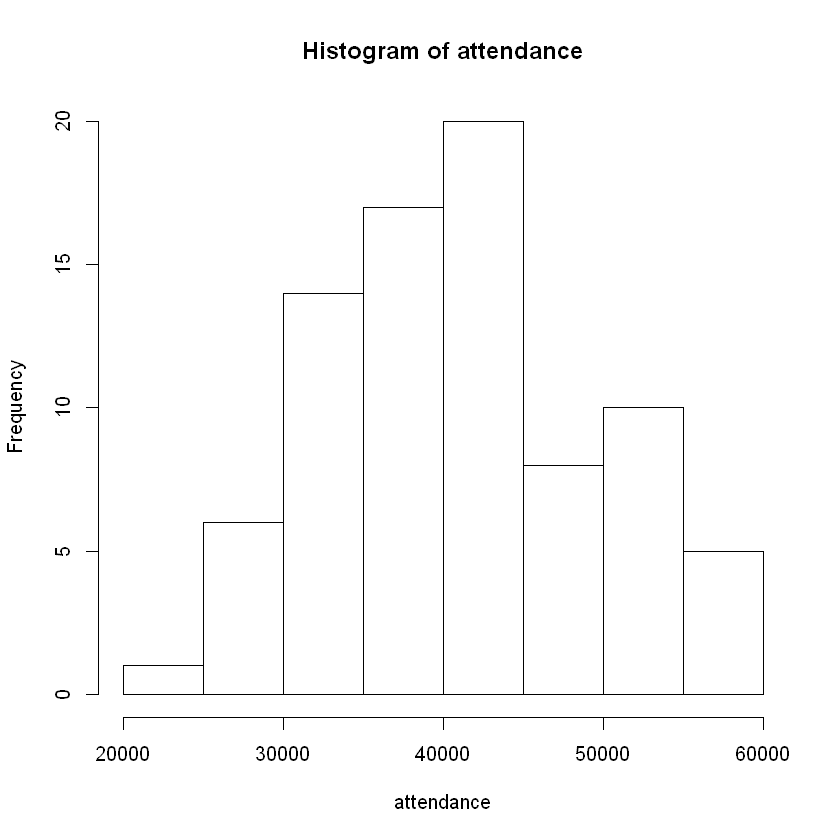

In [83]:
# Look at the histogram for attendance
attendance <- dodgers$attend
hist(attendance)

In [2]:
# Reoder days of the week to appear in chronological order versus alphabetical
dodgers$day_of_week <- factor(dodgers$day_of_week , levels=c("Sunday", "Monday", "Tuesday", "Wednesday", "Thursday",
                                                            "Friday", "Saturday"))

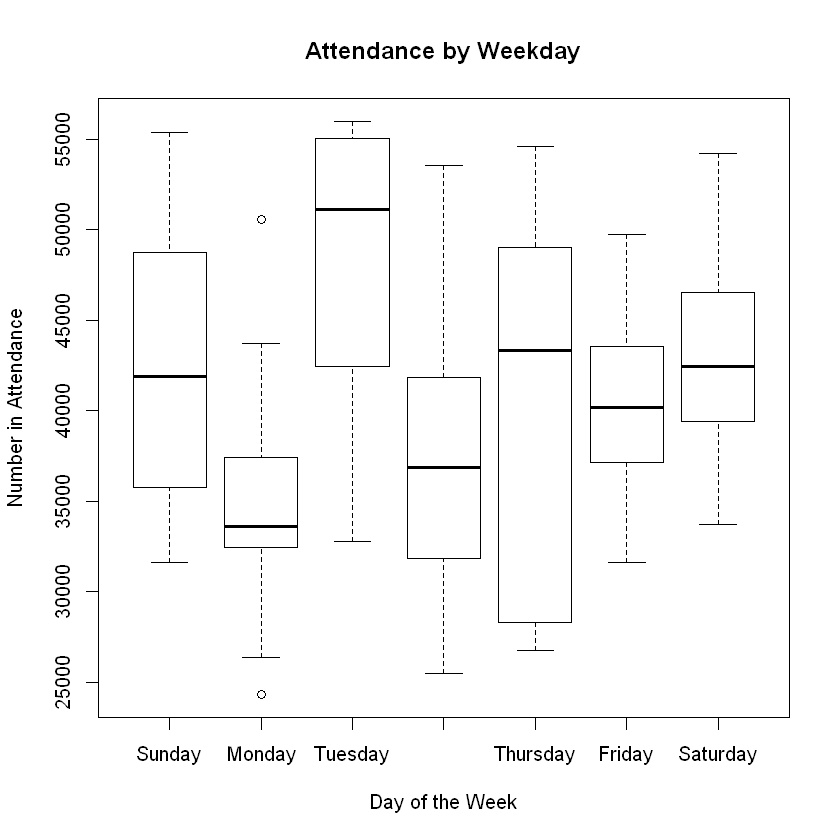

In [14]:
# Look at boxplot for attendance by day of week
boxplot(attend~day_of_week,data=dodgers, main="Attendance by Weekday",
   xlab="Day of the Week", ylab="Number in Attendance")

In [3]:
# Reoder months to appear in chronological order versus alphabetical
dodgers$month <- factor(dodgers$month , levels=c("APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT"))

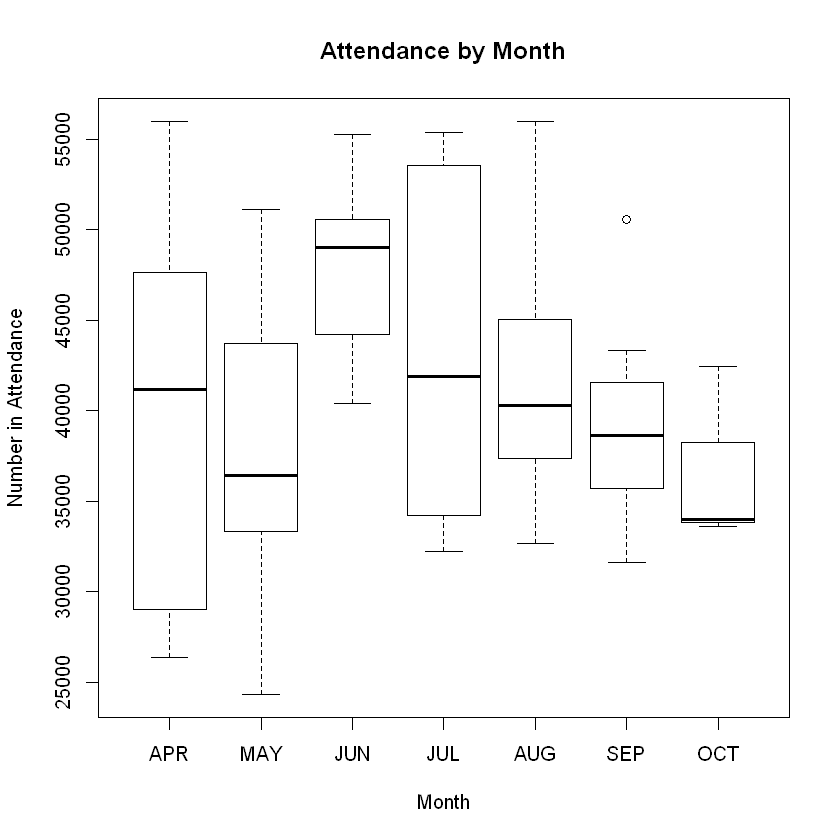

In [16]:
boxplot(attend~month,data=dodgers, main="Attendance by Month",
   xlab="Month", ylab="Number in Attendance")

Warning message:
"package 'ggplot2' was built under R version 3.6.3"

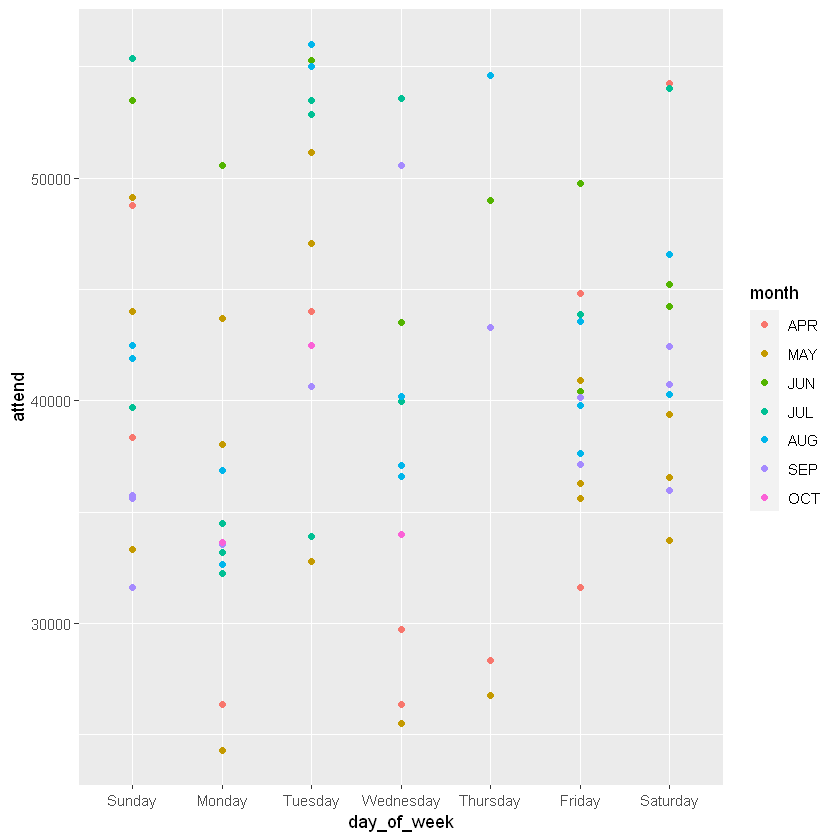

In [4]:
#Import ggplot library
library(ggplot2)

# Creat scatterplot
ggplot(dodgers, aes(x = day_of_week, y = attend)) +
  geom_point(aes(color = month)) 

Mondays and Wednesdays definitely stick out as far as low attendance goes. A couple months don't look so hot (May and Oct), but when I plotted attendance by day of week and month, it appears that Mondays, Wednesdays, and Thursdays in May and April generally have the worst attendance (less that 30000 per game). 

Before creating a model, I want to use RFE to find out what variables have the most influence over attendance.

In [35]:
# Install packages to use RFE 
library("dplyr")
library("faux")
library("DataExplorer")
library("caret")
library("randomForest")

In [36]:
# Define the control using a random forest selection function
control <- rfeControl(functions = rfFuncs, # random forest
                      method = "repeatedcv", # repeated cv
                      repeats = 5, # number of repeats
                      number = 10) # number of folds

In [42]:
# Split data into train-test sets

# Features
x <- dodgers %>%
  select(-attend) %>%
  as.data.frame()

# Target variable
y <- dodgers$attend

# Training: 80%; Test: 20%
set.seed(2021)
inTrain <- createDataPartition(y, p = .80, list = FALSE)[,1]

x_train <- x[ inTrain, ]
x_test  <- x[-inTrain, ]

y_train <- y[ inTrain]
y_test  <- y[-inTrain]

In [43]:
# Run RFE
result_rfe1 <- rfe(x = x_train, 
                   y = y_train, 
                   sizes = c(1:11),
                   rfeControl = control)

# Print the results
result_rfe1

# Print the selected features
predictors(result_rfe1)


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables RMSE Rsquared  MAE RMSESD RsquaredSD  MAESD Selected
         1 7162   0.4683 5815   1544     0.2216 1335.3         
         2 7460   0.3056 5961   1358     0.2434 1254.2         
         3 7218   0.3511 5782   1323     0.2718 1280.1         
         4 7143   0.3648 5822   1130     0.2740 1008.0         
         5 7137   0.3745 5850   1131     0.2780 1046.0         
         6 7120   0.3430 5850   1094     0.2693  881.5         
         7 7096   0.3573 5859   1108     0.2779  931.0         
         8 7053   0.3637 5817   1053     0.2727  851.2         
         9 7076   0.3573 5837   1071     0.2652  871.7         
        10 7034   0.3658 5799   1066     0.2735  871.3        *
        11 7045   0.3640 5825   1030     0.2720  868.9         

The top 5 variables (out of 10):
   bobblehead, day_of_week, opponent, month, temp


[1] "bobblehead"  "day_of_week" "opponent"    "month"       "temp"       
 [6] "shirt"       "fireworks"   "day"         "cap"         "day_night"

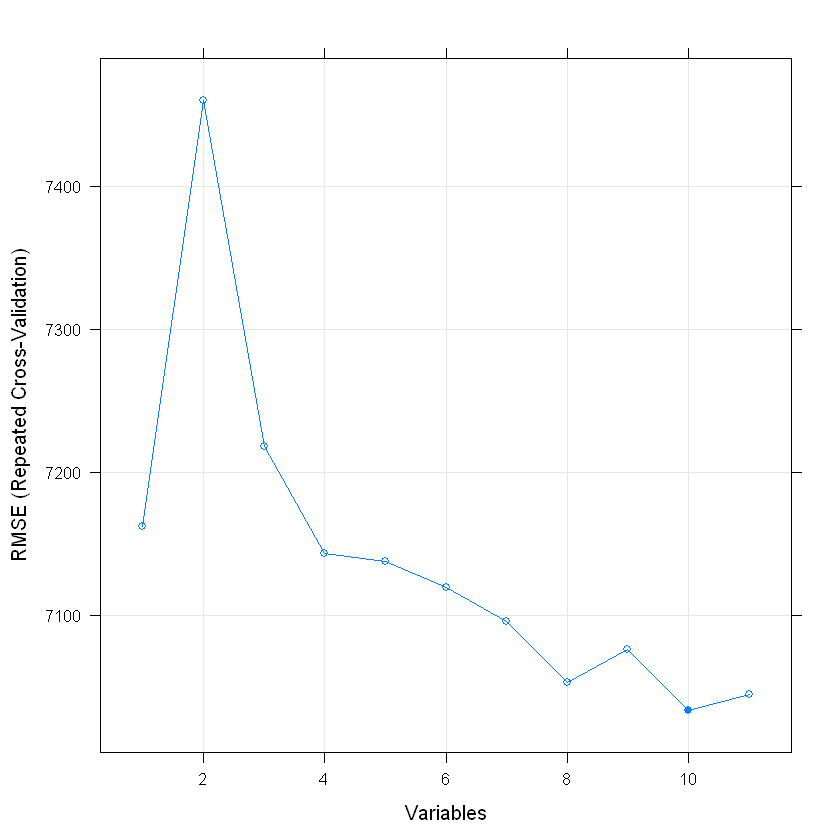

In [80]:
# Plot the RFE results
plot(result_rfe1, type=c("g", "o"))

In [73]:
# Use the model on test data
postResample(predict(result_rfe1, x_test), y_test)

RMSE     Rsquared          MAE 
7428.4876569    0.1835787 5940.2210714

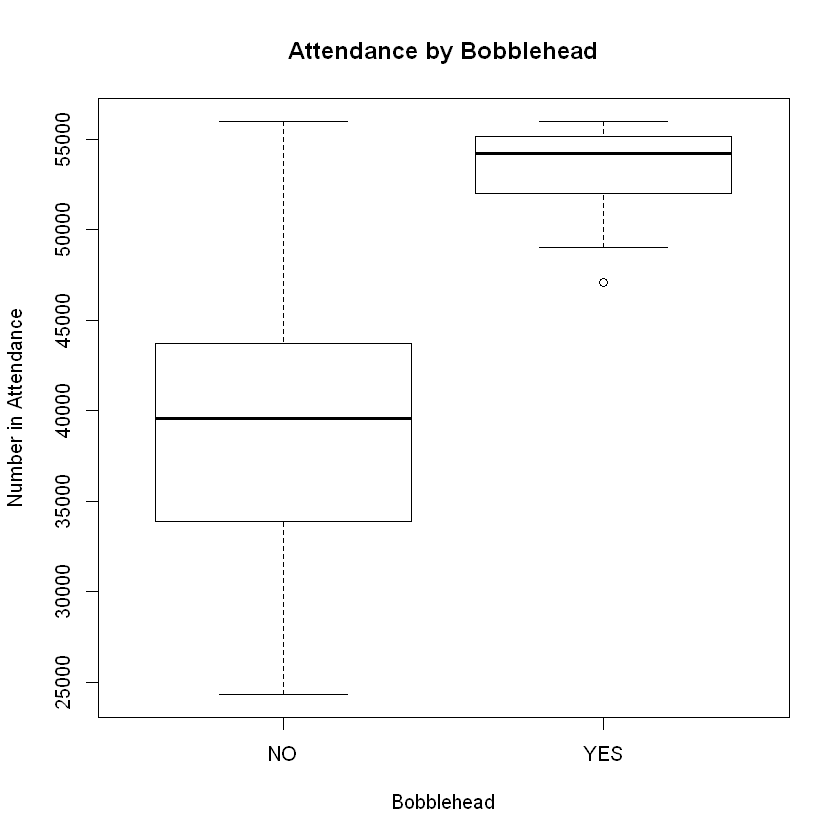

In [49]:
# RFE recommended that 10 features be used for our model.
# Because of feature selection results I want to take a look at the boxplot for bobbleheads
boxplot(attend~bobblehead,data=dodgers, main="Attendance by Bobblehead",
   xlab="Bobblehead", ylab="Number in Attendance")

In [59]:
# Now I am going to create a few models and use the anova test

# create baseline model for attendance. Use poisson regression model because attend is count data.
model_base <- glm(attend ~ 1, family = "poisson", data=dodgers)

# create model for attendance by days of week. 
model_days <- glm(attend ~ day_of_week, family = "poisson", data=dodgers)

# create model for attendance by days of week and month
model_both <- glm(attend ~ day_of_week + month, family = "poisson", data=dodgers)

# create modelrecommended by RFE
model_rfe <- glm(attend ~ day_of_week + opponent + month + bobblehead + temp + shirt + fireworks + day + cap + day_night,
                 family = "poisson", data=dodgers)

In [74]:
# Compare models
anova(model_base, model_days, model_both, model_rfe)

Resid. Df,Resid. Dev,Df,Deviance
80,135065.17,NA,NA
74,104517.80,6,30547.37
68,80314.34,6,24203.46
45,41725.39,23,38588.95


In [69]:
# The RFE recommended model had lower residual deviance, meaning it was a better fit and an R2 of 0.68, which is substantial.
# Let's take a look at the summary for it.
summary(model_rfe)


Call:
glm(formula = attend ~ day_of_week + opponent + month + bobblehead + 
    temp + shirt + fireworks + day + cap + day_night, family = "poisson", 
    data = dodgers)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-46.441  -17.190   -0.601    7.773   62.856  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          10.7196804  0.0138345 774.852  < 2e-16 ***
day_of_weekMonday    -0.0179428  0.0040756  -4.403 1.07e-05 ***
day_of_weekTuesday    0.2009465  0.0039921  50.336  < 2e-16 ***
day_of_weekWednesday -0.0126775  0.0038755  -3.271  0.00107 ** 
day_of_weekThursday   0.0076039  0.0046081   1.650  0.09891 .  
day_of_weekFriday    -0.4340108  0.0073674 -58.910  < 2e-16 ***
day_of_weekSaturday   0.0729555  0.0031977  22.815  < 2e-16 ***
opponentAstros       -0.5187919  0.0114120 -45.460  < 2e-16 ***
opponentBraves       -0.5008576  0.0111279 -45.009  < 2e-16 ***
opponentBrewers      -0.5894965  0.0121561 -48.494  < 2e-16

***Upon conducting analysis of the data my recommendation would be to run the marketing promo on Mondays in October. May has less attendees on Mondays in total, but October presents a slightly larger capacity for impact on attendance numbers. For the promotion, fireworks is the leading promotion, should that not be available, bobbleheads make the second most impact to total number of attendees.***